In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# import cv2

In [43]:
path="/home/dhruvgarg/Documents/Research Paper/Datasets/HDeviceCGM.txt"
df = pd.read_csv(path,parse_dates=['DexInternalTm'],date_format='ISO8601', delimiter='|')


df

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue
0,1655236,782,183,12,-6,05:35:41,-6.0,12:37:02,CGM,162.0
1,1655237,782,183,12,-6,05:30:41,-6.0,12:32:02,CGM,164.0
2,1655238,782,183,12,-6,05:25:41,-6.0,12:27:02,CGM,168.0
3,1655239,782,183,12,-6,05:20:41,-6.0,12:22:02,CGM,169.0
4,1655240,782,183,12,-6,05:15:41,-6.0,12:17:02,CGM,170.0
...,...,...,...,...,...,...,...,...,...,...
14950656,102858,1472,293,10,105,08:47:46,105.0,16:45:14,CGM,210.0
14950657,102859,1472,293,10,105,08:42:46,105.0,16:40:14,CGM,211.0
14950658,102860,1472,293,10,105,08:37:46,105.0,16:35:14,CGM,210.0
14950659,102861,1472,293,10,105,08:32:46,105.0,16:30:14,CGM,207.0


In [44]:
print(df.columns)

Index(['RecID', 'ParentHDeviceUploadsID', 'PtID', 'SiteID',
       'DeviceDtTmDaysFromEnroll', 'DeviceTm', 'DexInternalDtTmDaysFromEnroll',
       'DexInternalTm', 'RecordType', 'GlucoseValue'],
      dtype='object')


In [45]:
df[["PtID","DeviceTm","GlucoseValue","DexInternalTm"]]

df_pt183 = df.loc[df["PtID"]==183]

In [46]:
df_pt183=df_pt183.iloc[::-1]

In [47]:
visualizing_df=df_pt183[["DeviceTm","GlucoseValue"]]

In [6]:
df_pt183["glycemic_state"] = df_pt183["GlucoseValue"].apply(lambda x: 1 if x >= 170 else 2 if x<=60 else 0)

In [7]:
for i in df_pt183["glycemic_state"].unique():
    print(i," : ",df_pt183["glycemic_state"].value_counts().get(i,0))

0  :  50778
1  :  12528
2  :  971


There is a very clear gap between samples counts. Lets try to use simple weight adjustments to the loss function in the RNN first. We'll go forward from there. 

The next step is to create individual data samples that include these intervals. 

We'll try to use the sliding window technique to make our training data. We'll consider data of the previous 30 mins to start with and try to predict for an event occuring in the next 15-20 mins.

In [ ]:
window_size = 6    
look_ahead = 3     
future_window = 4  

training_data = []

for i in range(len(df_pt183) - window_size - look_ahead - future_window):

    input_window = df_pt183["GlucoseValue"].iloc[i : i + window_size].values
    
    future_start = i + window_size + look_ahead
    future_end = future_start + future_window
    
    future_readings = df_pt183["GlucoseValue"].iloc[future_start : future_end].values
    label = int(np.any(future_readings < 70) or np.any(future_readings > 180))  # 1 if event happens, else 0
    
    training_data.append((input_window, label))

training_data = np.array(training_data, dtype=object)

print("Number of training instances:", len(training_data))
print("Example training instance:", training_data[0])  # Example output


Number of training instfuture_window = 4  ance: [array([0., 0., 0., 0., 0., 0.]) 0]


In [ ]:
print("Number of training instfuture_window = 4  ance:", training_data[110])  # Example output


Number of training instfuture_window = 4  ance: [array([125., 135., 148., 159., 168., 175.]) 1]


In [10]:
X = np.array([entry[0] for entry in training_data]).reshape(len(training_data), window_size, 1)
y = np.array([entry[1] for entry in training_data])

In [11]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(6, 1)),  
    LSTM(25, return_sequences=False),  
    Dense(1, activation="sigmoid")  
    ])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=8, batch_size=32, validation_split=0.5)


2025-02-04 17:37:01.502545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738670821.516017   92977 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738670821.519907   92977 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 17:37:01.534709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/8


2025-02-04 17:37:03.995998: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/dhruvgarg/Documents/Research Paper/venv/lib64/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7668 - loss: 0.5259 - val_accuracy: 0.7869 - val_loss: 0.4760
Epoch 2/8
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7983 - loss: 0.4573 - val_accuracy: 0.8153 - val_loss: 0.4386
Epoch 3/8
703/703 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8188 - loss: 0.4343 - val_accuracy: 0.8165 - val_loss: 0.4370
Epoch 4/8
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8195 - loss: 0.4329 - val_accuracy: 0.8214 - val_loss: 0.4406
Epoch 5/8
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8201 - loss: 0.4340 - val_accuracy: 0.8177 - val_loss: 0.4280
Epoch 6/8
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8192 - loss: 0.4334 - val_accuracy: 0.8037 - val_loss: 0.4480
Epoch 7/8
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8187 - loss: 0.4328 - val_accuracy: 0.8278 - val_loss: 0.4222
Epoch 8/8
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8227 - loss: 0.4271 - val_accuracy: 0.8258 - val_loss: 0

In [40]:
y_pred_lstm = model.predict(X_test) > 0.5
accuracy_score(y_test,y_pred_lstm)

603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


0.8264522821576763

In [14]:
(14950661/226)/1440

45.9398383726647

In [15]:
# X_train.reshape(-1,5)[0]

In [16]:
stat_train = X_train.reshape(-1,6)
stat_test = X_test.reshape(-1,6)

In [36]:
len(stat_train)

44984

In [34]:
SVC_model = SVC(kernel='linear')

SVC_model.fit(stat_train[:1000],y_train[:1000])


SVC(kernel='linear')

In [35]:

y_pred_svc = SVC_model.predict(stat_test)
print(accuracy_score(y_pred_svc,y_test))

0.7545124481327801


In [37]:
forest = RandomForestClassifier()

forest.fit(stat_train,y_train)

RandomForestClassifier()

In [38]:
forest_pred = forest.predict(stat_test)
print(accuracy_score(forest_pred,y_test))

0.8230290456431535


In [41]:
import matplotlib.pyplot as plt

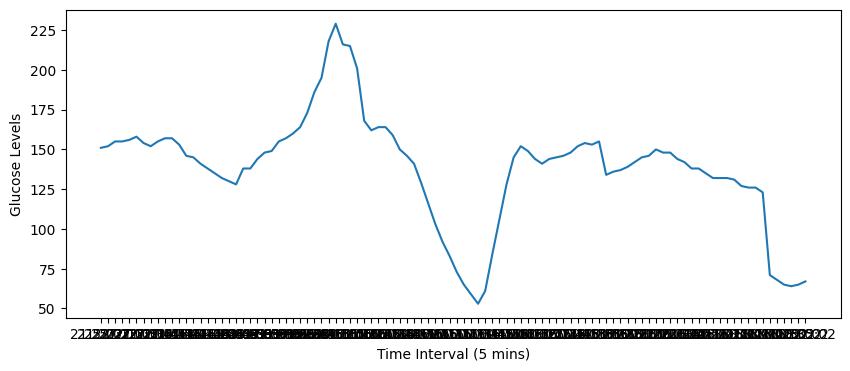

In [59]:
plt.figure(figsize=(10, 4))
# DeviceTm","GlucoseValue
plt.plot(visualizing_df['DeviceTm'].values[:100], visualizing_df['GlucoseValue'].values[:100], label='Glucose')
plt.scatter(df_pt183.loc[df_pt183['label'] == 1, 'DeviceTm'].values[:100], df_pt183.loc[df_pt183['label'] == 1, 'GlucoseValue'].values[:100], color='red', label='Potential Early Warning')
plt.xlabel("Time Interval (5 mins)")
plt.ylabel("Glucose Levels")

plt.savefig("Glucose patterns")
